In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

## Step 1. Dowload data

In [2]:
trans = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor()])
train_set = datasets.FashionMNIST(
             train=True, transform=trans, download=True, root='/Users/xiaochen/Downloads')
val_set = datasets.FashionMNIST(
            train=False, transform=trans, download=True, root='/Users/xiaochen/Downloads')

100%|██████████| 26421880/26421880 [00:06<00:00, 4067533.45it/s]


Extracting /Users/xiaochen/Downloads/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/xiaochen/Downloads/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 345713.68it/s]


Extracting /Users/xiaochen/Downloads/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/xiaochen/Downloads/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3196842.14it/s]


Extracting /Users/xiaochen/Downloads/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/xiaochen/Downloads/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9188202.98it/s]

Extracting /Users/xiaochen/Downloads/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/xiaochen/Downloads/FashionMNIST/raw



In [3]:
print(len(train_set))
print(len(val_set))

60000
10000


In [5]:
# X
train_set[0][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [6]:
# y
train_set[0][1]

9

In [4]:
train_set[0][0].shape

torch.Size([1, 32, 32])

In [5]:
def text_labels(indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

In [27]:
# define data generator
batch_size = 128
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [7]:
X, y = next(iter(train_dataloader))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([1, 1, 32, 32]) torch.float32 torch.Size([1]) torch.int64


In [9]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = np.array(img)
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


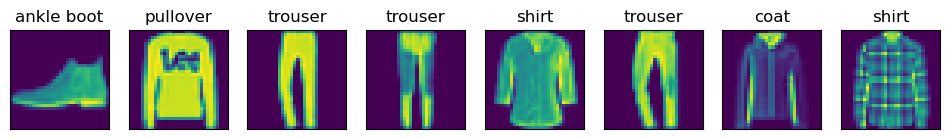

In [14]:
def visualize(batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = text_labels(y)
    show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(val_dataloader))

visualize(batch)

## Build linear classification model with PyTorch

In [22]:
class SoftmaxModel(nn.Module):
    def __init__(self, num_outputs: int, lr: float):
        """
        This function is required for Pytorch model
        """
        super(SoftmaxModel, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_outputs)
            # nn.Linear(1*32*32, num_outputs)
        )

    def forward(self, X):
        """
        This function is required for Pytorch Model
        """
        return self.net(X)


In [19]:
class SoftmaxModle_2(nn.Module):
    def __init__(self, num_outputs: int, lr: float):
        """
        This function is required for Pytorch model
        """
        super(SoftmaxModle_2, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.LazyLinear(num_outputs)

    def forward(self, X):
        """
        This function is required for Pytorch Model
        """
        return self.l1(self.flatten(X))

## Build a trainer 

In [32]:
# Model parameters
num_outputs = 10  # FashionMNIST has 10 classes
learning_rate = 0.1
epochs = 10  # Number of epochs to train

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
# If you have a windows or old mac without M-chip. Use the following line instead:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SoftmaxModel(num_outputs=num_outputs, lr=learning_rate).to(device)

loss_fn = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store the loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train() # tell pytorch to store and track gradients
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch, (images, labels) in enumerate(train_dataloader):
        # Move data to the same device as the model (GPU if available)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward() # Compute the gradients
        optimizer.step() # Update the parameters
        
        running_train_loss += loss.item() # Add the loss to the running total

        # Compute training accuracy
        _, predicted_train = torch.max(outputs, 1) # Get the predicted class
        total_train += labels.size(0) # Get the total number of labels
        correct_train += (predicted_train == labels).sum().item() 
        # Count the number of correct predictions

    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)  # Track the training loss
    
    train_accuracy = correct_train / total_train * 100
    train_accuracies.append(train_accuracy)  # Track the training accuracy

    # You can save the model here if you want to
    torch.save(model.state_dict(), f'/model_epoch{epoch}.pth')
    
    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Calculate validation loss
            val_loss = loss_fn(outputs, labels)
            running_val_loss += val_loss.item()
            
            # Calculate validation accuracy
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # Track the validation loss
    
    val_accuracy = correct_val / total_val * 100
    val_accuracies.append(val_accuracy)  # Track the validation accuracy

    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Training Loss: 0.6959, Training Accuracy: 76.55%, Validation Loss: 0.5631, Validation Accuracy: 81.07%
Epoch [2/10], Training Loss: 0.5306, Training Accuracy: 81.82%, Validation Loss: 0.5254, Validation Accuracy: 81.69%
Epoch [3/10], Training Loss: 0.4966, Training Accuracy: 83.12%, Validation Loss: 0.5349, Validation Accuracy: 80.59%
Epoch [4/10], Training Loss: 0.4788, Training Accuracy: 83.59%, Validation Loss: 0.5140, Validation Accuracy: 81.09%
Epoch [5/10], Training Loss: 0.4674, Training Accuracy: 84.05%, Validation Loss: 0.5154, Validation Accuracy: 82.45%
Epoch [6/10], Training Loss: 0.4583, Training Accuracy: 84.23%, Validation Loss: 0.5278, Validation Accuracy: 80.34%
Epoch [7/10], Training Loss: 0.4502, Training Accuracy: 84.55%, Validation Loss: 0.4931, Validation Accuracy: 82.37%
Epoch [8/10], Training Loss: 0.4420, Training Accuracy: 84.75%, Validation Loss: 0.4835, Validation Accuracy: 83.15%
Epoch [9/10], Training Loss: 0.4401, Training Accuracy: 84.92%, 

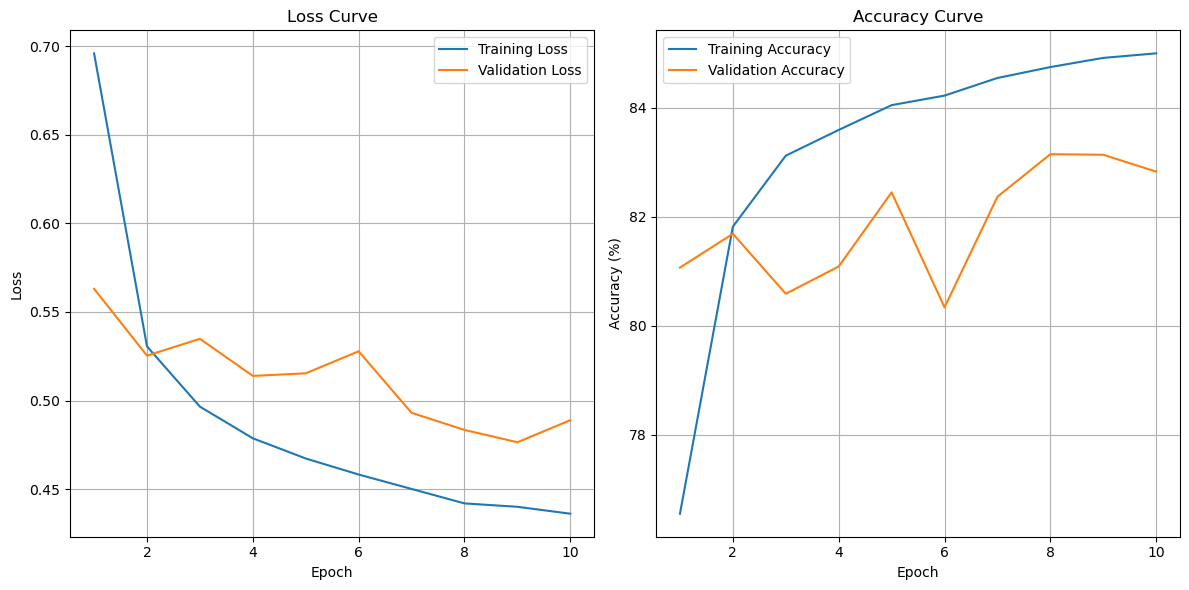

In [33]:
# Plot the learning curve
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Summary
This is a very simple single-layer linear classfication model. The performance is reasonable. But we can do much better job in later class.

## Load pre-trainined model and conduct inference (test data)

In [ ]:
# load pre-trained model
best_pre_trained_model = SoftmaxModel.load_model(f'/model_epoch{epoch}.pth')
best_pre_trained_model.to(device)
best_pre_trained_model.eval()

# build test dataset and dataloader
# Here I do not have test dataset, I will use val_set as example
test_set = val_set

# build test dataloader
test_loader = DataLoader(test_set, batch_size=1, shuffle=False) # So far we will set batch size to 1 for testing

# But in later class, we will use batch size > 1 for testing, so we need to modify the code accordingly.

correct = 0
total = 0
for img, lable in test_loader:
    pred_res = best_pre_trained_model(img.to(device))
    pred_label = torch.argmax(pred_res, dim=1)
    total += 1
    if pred_label == lable.item():
        correct += 1

print(f"Test Accuracy: {correct/total}")